In [8]:
import math, copy

import numpy as np

import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt

from LoadSynthetic import *

mpl.rcParams['text.usetex'] = True
mpl.rcParams['svg.fonttype'] = 'none'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [11]:
alpha = 0.1
z = st.norm.ppf(1 - alpha / 2)
test_size = 1000
dim = 5
low, high = 0, 10
save = True
classes = 3
seeds = [574594, 900164,  33991, 205532,  65012, 389774, 169373, 769356,
       724626, 559168, 781740, 199310,  84367, 514742, 570831, 245193,
       724009, 801124, 583112, 724682]

def inflated_quantile(scores, q = 0.9):
    return np.sort(scores)[math.ceil(q * (1 + len(scores))) - 1]

In [12]:
def routine(mean_modifier = lambda x, y: x, var_modifier = lambda x, y: y, selector = lambda x: x >= 0):

    np.random.seed(15)
    X = np.random.uniform(low = low, high = high, size = (5000, dim))

    sampler = ConditionalNormal(*getStatistics("mean", .1))
    y, mean, var = sampler.sample(X)

    order = np.argsort(var)
    y, mean, var = y[order], mean[order], var[order]

    def splitter(var):
        splits = np.quantile(var, [i * (1 / classes) for i in range(classes + 1)])
        splits[0] = -np.infty
        splits[-1] = np.infty
        grid = np.stack([splits[i:i+2] for i in range(len(splits) - 1)], axis = 0)

        def checker(x):
            index = np.zeros_like(x, dtype = int)
            for i in range(grid.shape[0]):
                index[(x >= grid[i, 0]) & (x <= grid[i, 1])] = i
            return index
        
        return checker, splits

    true_var = copy.deepcopy(var)
    taxonomy, splits = splitter(true_var)
    true_indices = taxonomy(var)
    labels = ["Low variance", "Medium variance", "High variance"]

    true_n_score = np.abs(mean - y) / np.sqrt(var)
    plt.figure()
    plt.title("True normalized scores")
    for i in range(len(labels)):
        plt.hist(true_n_score[true_indices == i], label = labels[i], alpha = 0.5, bins = 30)
    plt.show()
    plt.close()

    select = selector(var)
    mean[select] = mean_modifier(mean[select], var[select])
    var[select] = var_modifier(mean[select], var[select])

    cumsum = 0
    plt.figure()
    plt.title("Variance plot")
    for i in range(classes):
        plt.scatter(range(cumsum, cumsum + np.sum(true_indices == i)), var[true_indices == i], label = labels[i], marker=".", s=1)
        plt.plot(range(cumsum, cumsum + np.sum(true_indices == i)), true_var[true_indices == i], linestyle = "dashed")
        cumsum += np.sum(true_indices == i)
    plt.legend(loc = "upper left")
    plt.xticks([])
    if save:
        plt.savefig("./PLOTS/variance.jpg", dpi = 320, bbox_inches = "tight")
        plt.savefig("./PLOTS/variance.svg", dpi = 320, bbox_inches = "tight")
    plt.show()
    plt.close()

    plt.figure()
    plt.title("Variance comparison")
    plt.xlabel("True variance")
    plt.ylabel("Estimated variance")
    for i in range(classes):
        plt.scatter(true_var[true_indices == i], var[true_indices == i], label = labels[i], marker=".", s=1)
    plt.scatter(true_var, true_var, label = True, marker=".", s=1, color = "grey")
    plt.legend()
    if save:
        plt.savefig("./PLOTS/variance_comparison.jpg", dpi = 320, bbox_inches = "tight")
        plt.savefig("./PLOTS/variance_comparison.svg", dpi = 320, bbox_inches = "tight")
    plt.show()
    plt.close()

    order = np.argsort(var)
    true_var, true_n_score, true_indices = true_var[order], true_n_score[order], true_indices[order]
    y, mean, var = y[order], mean[order], var[order]
    taxonomy, splits = splitter(var)
    indices = taxonomy(var)

    plt.figure()
    plt.title("Variance comparison")
    plt.xlabel("True variance")
    plt.ylabel("Estimated variance")
    for i in range(classes):
        plt.scatter(true_var[indices == i], var[indices == i], label = labels[i], marker=".", s=1, color = colors[i])
        plt.scatter(true_var[true_indices == i], true_var[true_indices == i], marker=".", s=1, color = colors[i])
    plt.legend()
    if save:
        plt.savefig("./PLOTS/variance_after.jpg", dpi = 320, bbox_inches = "tight")
        plt.savefig("./PLOTS/variance_after.svg", dpi = 320, bbox_inches = "tight")
    plt.show()
    plt.close()

    chi = lambda x: x       # to modifiy the standard deviation

    score = np.abs(mean - y)
    n_score = np.abs(mean - y) / chi(np.sqrt(var))
    int_score = np.abs(mean - y) - z * np.sqrt(var)
    st_score = (y - mean) / chi(np.sqrt(var))

    plt.figure()
    plt.title("Normalized scores")
    for i in range(classes):
        plt.scatter(true_n_score[true_indices == i], n_score[true_indices == i])
    for i in range(classes):
        plt.scatter([inflated_quantile(true_n_score[true_indices == i], 1-alpha)], [inflated_quantile(n_score[true_indices == i], 1-alpha)], color = "red")
    plt.plot([0, 4], [0, 4], color = "red")
    plt.show()
    plt.close()
    plt.figure()
    plt.title("Normalized scores")
    for i in range(classes):
        plt.scatter(true_n_score[indices == i], n_score[indices == i])
    for i in range(classes):
        plt.scatter([inflated_quantile(true_n_score[indices == i], 1-alpha)], [inflated_quantile(n_score[indices == i], 1-alpha)], color = "red")
    plt.plot([0, 4], [0, 4], color = "red")
    plt.show()
    plt.close()

    def res():
        crit = inflated_quantile(score, 1 - alpha)
        return lambda y, m, v: np.mean((y >= m - crit) & (y <= m + crit)), \
            lambda m, v: 2 * crit

    def norm():
        crit = inflated_quantile(n_score, 1 - alpha)
        return lambda y, m, v: np.mean((y >= m - crit * chi(np.sqrt(v))) & (y <= m + crit * chi(np.sqrt(v)))), \
            lambda m, v: 2 * np.mean(crit * chi(np.sqrt(v)))

    def interval():
        crit = inflated_quantile(int_score, 1 - alpha)
        return lambda y, m, v: np.mean((y >= m - crit - z * np.sqrt(v)) & (y <= m + crit + z * np.sqrt(v))), \
            lambda m, v: 2 * np.mean(crit + z * np.sqrt(v))

    def stand():
        lower = inflated_quantile(st_score, alpha / 2)
        upper = inflated_quantile(st_score, 1 - alpha / 2)
        return lambda y, m, v: np.mean((y >= m + lower * np.sqrt(v)) & (y <= m + upper * np.sqrt(v))), \
            lambda m, v: np.mean((upper - lower) * np.sqrt(v))

    with open("./PLOTS/covs.txt", "w" if save else "a") as file:
        with open("./PLOTS/widths.txt", "w" if save else "a") as file2:
            # for n, s, f in [("Residual", score, res), ("Normalized", n_score, norm),
                # ("Interval", int_score, interval), ("Normalized CPS", st_score, stand)]:
            for n, s, f in [("Residual", score, res), ("Normalized", n_score, norm)]:

                plt.figure()
                plt.title(n)
                for i in range(classes):
                    values, base = np.histogram(s[indices == i], bins=40)
                    cumulative = np.cumsum(values)
                    plt.plot(base[:-1], cumulative / len(s[indices == i]), label = labels[i])

                values, base = np.histogram(s, bins=40)
                cumulative = np.cumsum(values)
                plt.plot(base[:-1], cumulative / len(s), label = "Marginal")
                plt.hlines(1 - alpha, base[0], base[-1], linestyles="dashed", color = "red", label = "Significance threshold")

                plt.legend(loc = "lower right")
                if save:
                    plt.savefig("./PLOTS/" + n + "-CDF.svg", dpi = 320, bbox_inches = 'tight')
                    plt.savefig("./PLOTS/" + n + "-CDF.jpg", dpi = 320, bbox_inches = 'tight')
                plt.show()
                plt.close()

                g, h = f()

                covs = np.zeros((20, len(np.unique(indices)) + 1))
                widths = np.zeros((20, len(np.unique(indices)) + 1))
                for j in range(covs.shape[0]):

                    np.random.seed(seeds[j])
                    X_ = np.random.uniform(low = low, high = high, size = (test_size, dim))
                    y_, mean_, var_ = sampler.sample(X_)
                    select = selector(var_)
                    mean_[select] = mean_modifier(mean_[select], var_[select])
                    var_[select] = var_modifier(mean_[select], var_[select])
                    inds = taxonomy(var_)
                    
                    covs[j, 0] = g(y_, mean_, var_)
                    widths[j, 0] = h(mean_, var_)
                    for i in range(len(np.unique(indices))):
                        covs[j, 1 + i] = g(y_[inds == i], mean_[inds == i], var_[inds == i]) if np.sum(inds == i) > 0 else -1
                        widths[j, 1 + i] = h(mean_[inds == i], var_[inds == i]) if np.sum(inds == i) > 0 else -1

                cov_means = np.round(np.mean(covs, axis = 0), 3)
                cov_stds = np.round(np.std(covs, axis = 0), 3)
                width_means = np.round(np.mean(widths, axis = 0), 3)
                width_stds = np.round(np.std(widths, axis = 0), 3)

                print(n)
                for i in range(len(np.unique(indices)) + 1):
                    print(("M: " if i == 0 else "") + str(cov_means[i]) + " -- " + str(cov_stds[i]))
                print()
                for i in range(len(np.unique(indices)) + 1):
                    print(("M: " if i == 0 else "") + str(width_means[i]) + " -- " + str(width_stds[i]))
                print()

                if save:
                    file.write(n + "\n")
                    file2.write(n + "\n")
                    for i in range(len(np.unique(indices)) + 1):
                        file.write(str(cov_means[i]) + "\pm" + str(cov_stds[i]) + "\n")
                        file2.write(str(width_means[i]) + "\pm" + str(width_stds[i]) + "\n")
                    file.write("\n")
                    file2.write("\n")

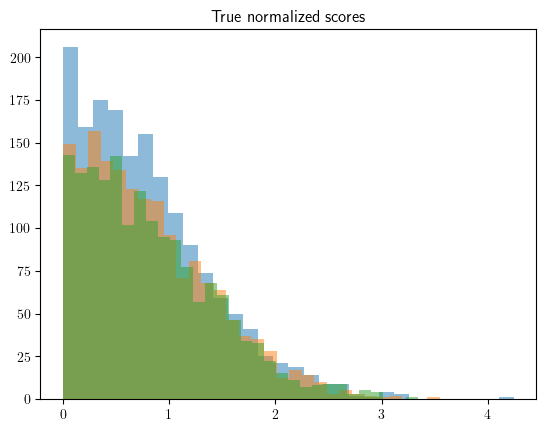

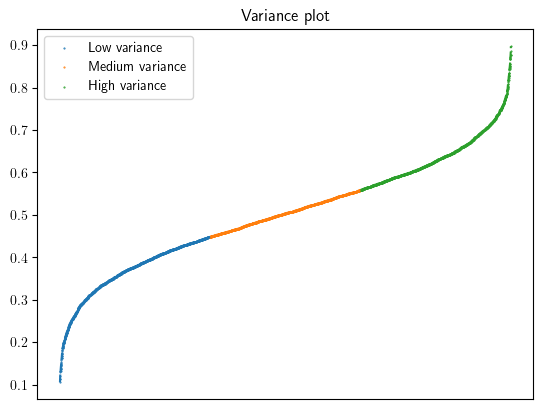

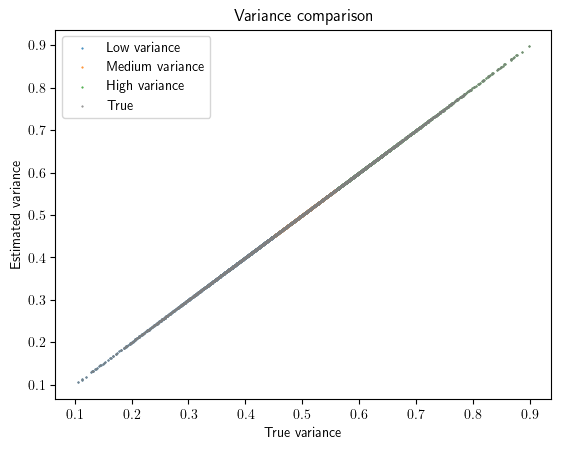

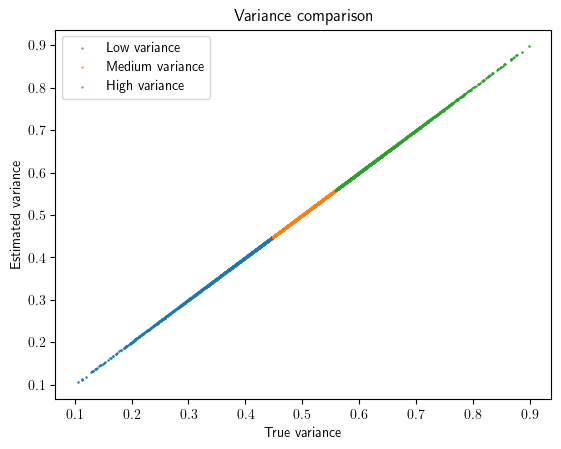

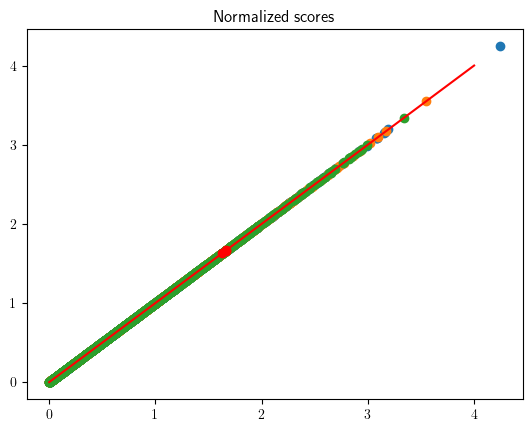

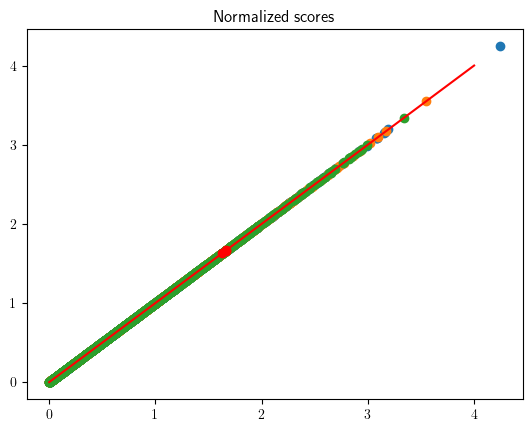

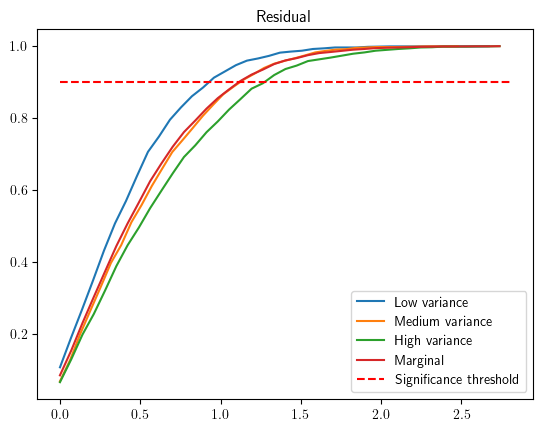

Residual
M: 0.905 -- 0.008
0.951 -- 0.01
0.904 -- 0.017
0.856 -- 0.018

M: 2.359 -- 0.0
2.359 -- 0.0
2.359 -- 0.0
2.359 -- 0.0



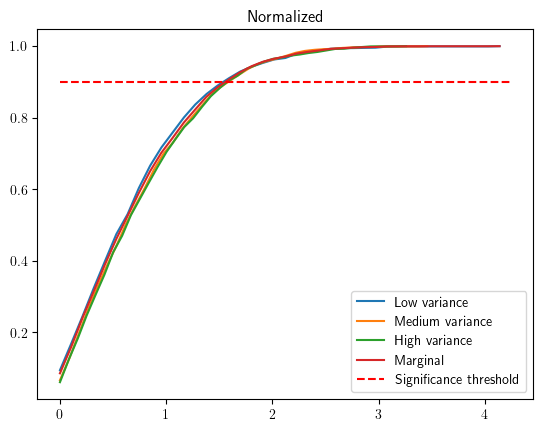

Normalized
M: 0.902 -- 0.008
0.905 -- 0.018
0.902 -- 0.015
0.898 -- 0.017

M: 2.318 -- 0.01
1.98 -- 0.011
2.347 -- 0.003
2.652 -- 0.006



In [13]:
routine()

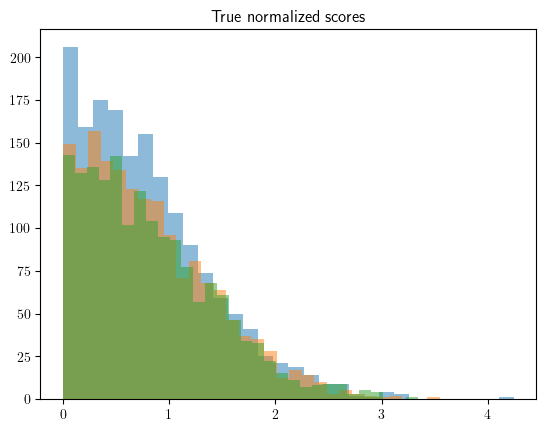

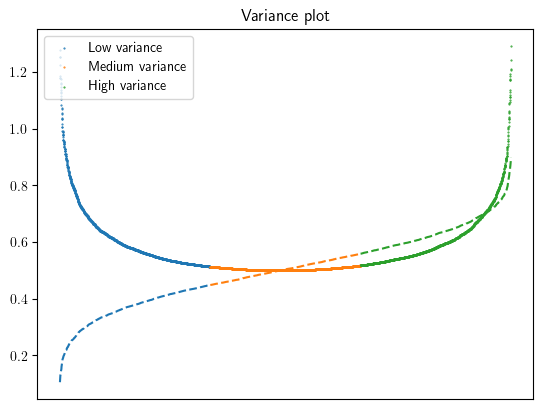

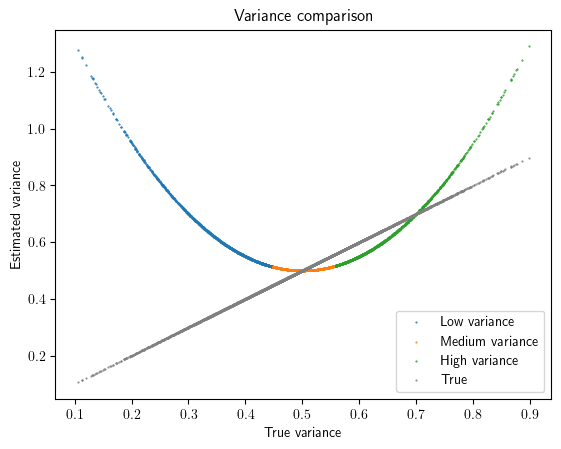

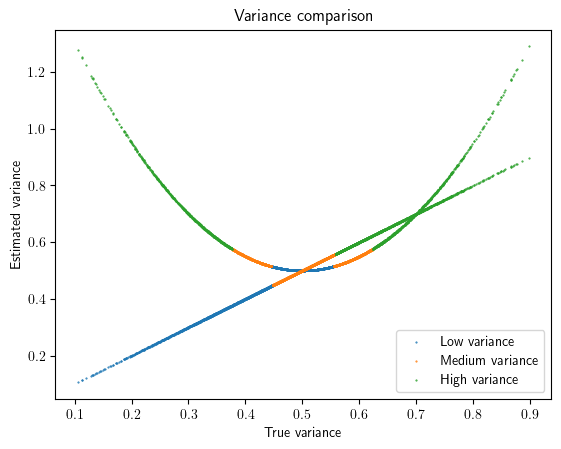

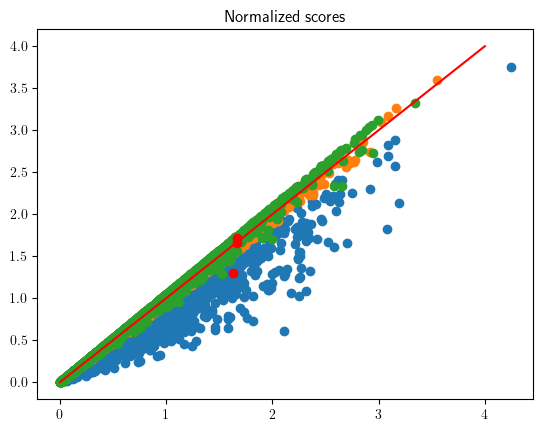

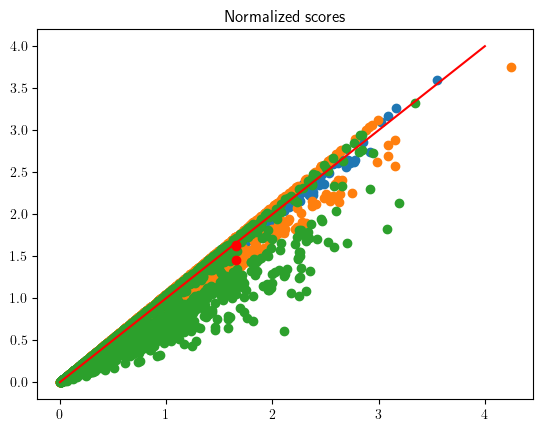

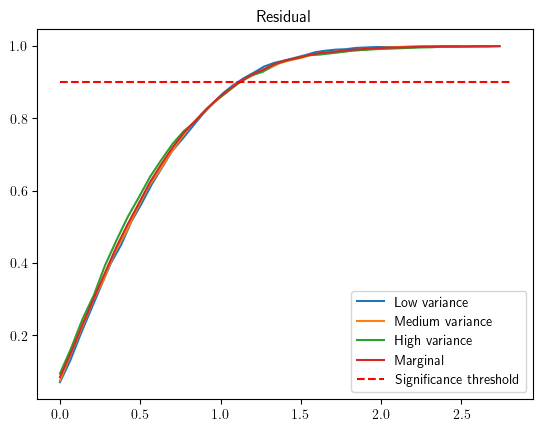

Residual
M: 0.905 -- 0.008
0.905 -- 0.017
0.905 -- 0.014
0.905 -- 0.012

M: 2.359 -- 0.0
2.359 -- 0.0
2.359 -- 0.0
2.359 -- 0.0



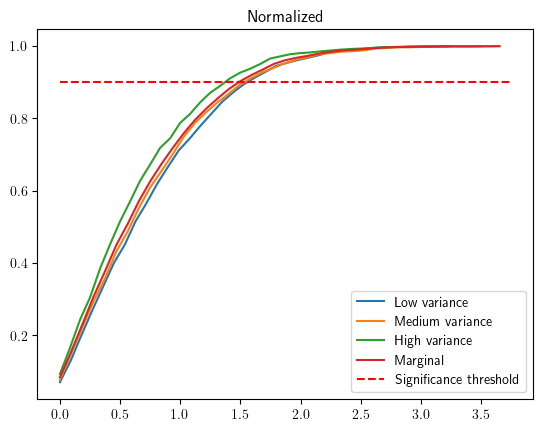

Normalized
M: 0.905 -- 0.008
0.886 -- 0.017
0.897 -- 0.014
0.931 -- 0.008

M: 2.39 -- 0.006
2.23 -- 0.001
2.308 -- 0.002
2.614 -- 0.009



In [16]:
routine(var_modifier = lambda x, y: 5 * ((y - .5) ** 2) + .5)